# 일별 지하철 예측 모델

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import warnings
warnings.filterwarnings('ignore')

In [40]:
df = pd.read_csv('2023_2024_지하철_컬럼변경완료최종.csv', encoding='utf-8')
df2 = pd.read_csv('result_202503.csv', encoding='utf-8')

In [41]:
# !pip uninstall prophet cmdstanpy -y
# !pip install prophet

In [42]:
df['총이용량'] = df['총승차량'] + df['총하차량']
df2['총이용량'] = df2['총승차량'] + df2['총하차량']

In [43]:
df2['수송일자'] = pd.to_datetime(df2['수송일자'].astype(str), format='%Y%m%d')
df2.rename(columns={'역명': '지하철역'}, inplace=True)

In [45]:
import pandas as pd

all_holidays = pd.DataFrame({
    'ds': pd.to_datetime([
        '2023-01-01', '2023-01-21', '2023-01-22', '2023-01-23', '2023-01-24', '2023-03-01', '2023-05-05', '2023-05-27', '2023-05-29','2023-06-06', '2023-08-15','2023-09-28', '2023-09-29', '2023-09-30','2023-10-03', '2023-10-09', '2023-12-25',
        '2024-01-01', '2024-02-09', '2024-02-10', '2024-02-11', '2024-02-12', '2024-03-01', '2024-04-10', '2024-05-05', '2024-05-06', '2024-05-15','2024-06-06', '2024-08-15','2024-09-16', '2024-09-17', '2024-09-18','2024-10-03', '2024-10-09', '2024-12-25',
        '2025-01-01', '2025-01-27', '2025-01-28', '2025-01-29', '2025-01-30', '2025-03-01', '2025-03-03', '2025-05-05', '2025-05-06', '2025-06-03', '2025-06-06', '2025-08-15', '2025-10-03', '2025-10-05', '2025-10-06', '2025-10-07', '2025-10-08', '2025-10-09', '2025-12-25',
    ]),
    'holiday': [
        '신정', '설날', '설날', '설날', '대체공휴일', '삼일절', '어린이날', '부처님오신날', '대체공휴일', '현충일', '광복절', '추석', '추석', '추석', '개천절', '한글날', '크리스마스',
        '신정', '설날', '설날', '설날', '대체공휴일', '삼일절', '국회의원선거', '어린이날', '대체공휴일', '부처님오신날', '현충일', '광복절', '추석', '추석', '추석', '개천절', '한글날', '크리스마스',
        '신정', '임시공휴일', '설날', '설날', '설날', '삼일절', '대체공휴일', '어린이날', '대체공휴일', '대통령선거', '현충일', '광복절', '개천절', '추석', '추석', '추석', '대체공휴일', '한글날', '크리스마스'
    ]
})

In [46]:
def simplify_holiday_labels(df):
    df = df.copy()
    df['holiday'] = df['ds'].dt.weekday.map(lambda d: '공휴일_주말' if d >= 5 else '공휴일_주중')
    return df

all_holidays = simplify_holiday_labels(all_holidays)

In [47]:
import pandas as pd
from prophet import Prophet

def run_prophet_with_outlier_removal(df, station_name, start_date, end_date, holidays_df=None):
    try:
        
        df_station = df[df['지하철역'] == station_name].copy()
        
        
        if df_station.empty:
            raise ValueError(f"[{station_name}] 역에 해당하는 데이터가 없습니다.")

        df_prophet = df_station[['수송일자', '총이용량']].rename(columns={'수송일자': 'ds', '총이용량': 'y'})
        df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
        
        # missing_count = df_prophet.isnull().sum()
        # print("결측값 개수:\n", missing_count)
        # # y 컬럼에서 음수 개수 확인
        # negative_count = (df_prophet['y'] < 0).sum()
        # print("음수 값 개수:", negative_count)
        
        
        df_prophet = df_prophet.dropna()
        df_prophet = df_prophet[df_prophet['y'] >= 0]
        
        threshold = 1.5
        Q1 = df_prophet['y'].quantile(0.25)
        Q3 = df_prophet['y'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df_clean = df_prophet[(df_prophet['y'] >= lower_bound) & (df_prophet['y'] <= upper_bound)]

        print(f"이상치 제거 전 데이터 수: {len(df_prophet)}")
        print(f"이상치 제거 후 데이터 수: {len(df_clean)}")
        
        import matplotlib.pyplot as plt
        import seaborn as sns

        # 이상치 포함 데이터와 제거 후 데이터를 합쳐서 박스플롯용 데이터프레임 생성
        plt.figure(figsize=(12, 6))
        plt.plot(df_prophet['ds'], df_prophet['y'], label='전체 데이터', color='lightgray')
        plt.scatter(df_prophet[~df_prophet.index.isin(df_clean.index)]['ds'],
                    df_prophet[~df_prophet.index.isin(df_clean.index)]['y'],
                    color='red', label='제거된 이상치')

        plt.title(f'{station_name}역 - 총이용량 이상치 식별 (시계열)')
        plt.xlabel('날짜')
        plt.ylabel('총이용량')
        plt.legend()
        plt.grid(True)
        plt.show()


        model = Prophet(
            holidays=holidays_df,
            daily_seasonality=False,
            seasonality_mode='additive',
            changepoint_prior_scale=0.05,
        )
        model.fit(df_clean)

        future_dates = pd.date_range(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date))
        future = pd.DataFrame({'ds': future_dates})
        forecast = model.predict(future)

        return model, forecast, df_clean

    except Exception as e:
        print(f"오류 발생: {e}")
        return None, None, None


In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_and_plot_forecast(forecast, actual_df, station_name, start_date, end_date):

    try:
        forecast_filtered = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)].copy()
        forecast_filtered['yhat'] = forecast_filtered['yhat'].clip(lower=0)
        actual_filtered = actual_df[(actual_df['지하철역'] == station_name) &
                                    (actual_df['수송일자'] >= start_date) &
                                    (actual_df['수송일자'] <= end_date)].copy()
        actual_filtered = actual_filtered[['수송일자', '총이용량']].rename(columns={'수송일자': 'ds', '총이용량': 'actual'})
        merged = pd.merge(forecast_filtered[['ds', 'yhat']], actual_filtered, on='ds', how='inner')


        y_true = merged['actual']
        y_pred = merged['yhat']
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        
        print("====성능 지표====")
        print(f"MAE (평균절대오차): {mae:.2f}")
        print(f"MSE (평균제곱오차): {mse:.2f}")
        print(f"RMSE (제곱근평균제곱오차): {rmse:.2f}")
        print(f"R² Score (설명력): {r2:.4f} (1에 가까울수록 예측이 정확함)")


        plt.figure(figsize=(14, 6))
        plt.plot(merged['ds'], y_pred, label='예측값 (yhat)', color='blue', marker='o')
        plt.plot(merged['ds'], y_true, label='실제값', color='orange', marker='x')
        
        plt.fill_between(forecast_filtered['ds'], 
            forecast_filtered['yhat_lower'], 
            forecast_filtered['yhat_upper'], 
            color='blue', alpha=0.2, label='예측 신뢰구간 (95%)')
        
        plt.title(f"{station_name}역 {start_date} ~ {end_date} 승하차량 예측 vs 실제")
        plt.xlabel('날짜')
        plt.ylabel('승차 인원 수')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        return merged

    except Exception as e:
        print(f"평가/시각화 오류: {e}")


이상치 제거 전 데이터 수: 731
이상치 제거 후 데이터 수: 727


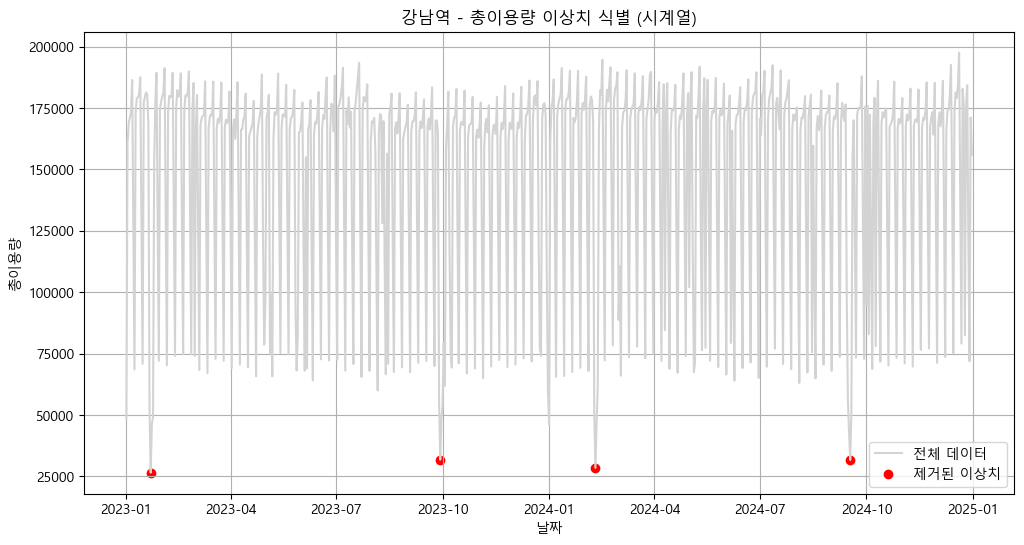

14:45:08 - cmdstanpy - INFO - Chain [1] start processing
14:45:08 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
model, forecast, cleaned_data = run_prophet_with_outlier_removal(
    df=df,
    station_name='강남',
    start_date='2025-03-01',
    end_date='2025-03-31',
    holidays_df=all_holidays
)

====성능 지표====
MAE (평균절대오차): 3741.68
MSE (평균제곱오차): 25225320.65
RMSE (제곱근평균제곱오차): 5022.48
R² Score (설명력): 0.9865 (1에 가까울수록 예측이 정확함)


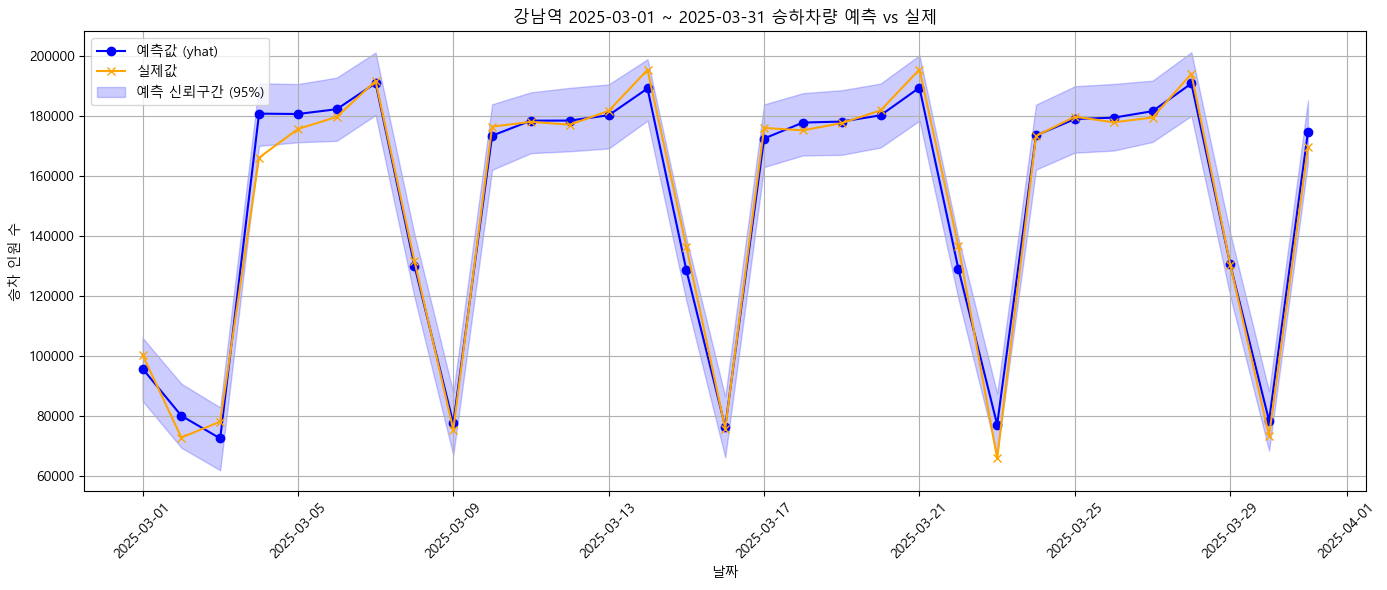

In [50]:
merged = evaluate_and_plot_forecast(
    forecast=forecast,
    actual_df=df2,
    station_name='강남',
    start_date='2025-03-01',
    end_date='2025-03-31',
)

In [51]:
# model.plot_components(forecast)

In [52]:
forecast[forecast['ds'] == '2025-03-03'][['ds', 'yhat', 'holidays', 'weekly', 'yearly', 'trend']]

,ds,yhat,holidays,weekly,yearly,trend
2,2025-03-03,72554.583652,-103227.099984,15020.447886,5556.820633,155204.415117


In [53]:
import matplotlib.pyplot as plt

def plot_forecast_error_over_time(merged_df, station_name):
    try:
        merged_df['error'] = merged_df['actual'] - merged_df['yhat']

        plt.figure(figsize=(14, 6))
        plt.plot(merged_df['ds'], merged_df['error'], marker='o', color='red', label='예측 오차 (실제 - 예측)')
        plt.axhline(0, color='black', linestyle='--', linewidth=1)
        plt.title(f"{station_name}역 날짜별 예측 오차")
        plt.xlabel("날짜")
        plt.ylabel("오차 (승차 인원 수)")
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"오차 시각화 오류: {e}")


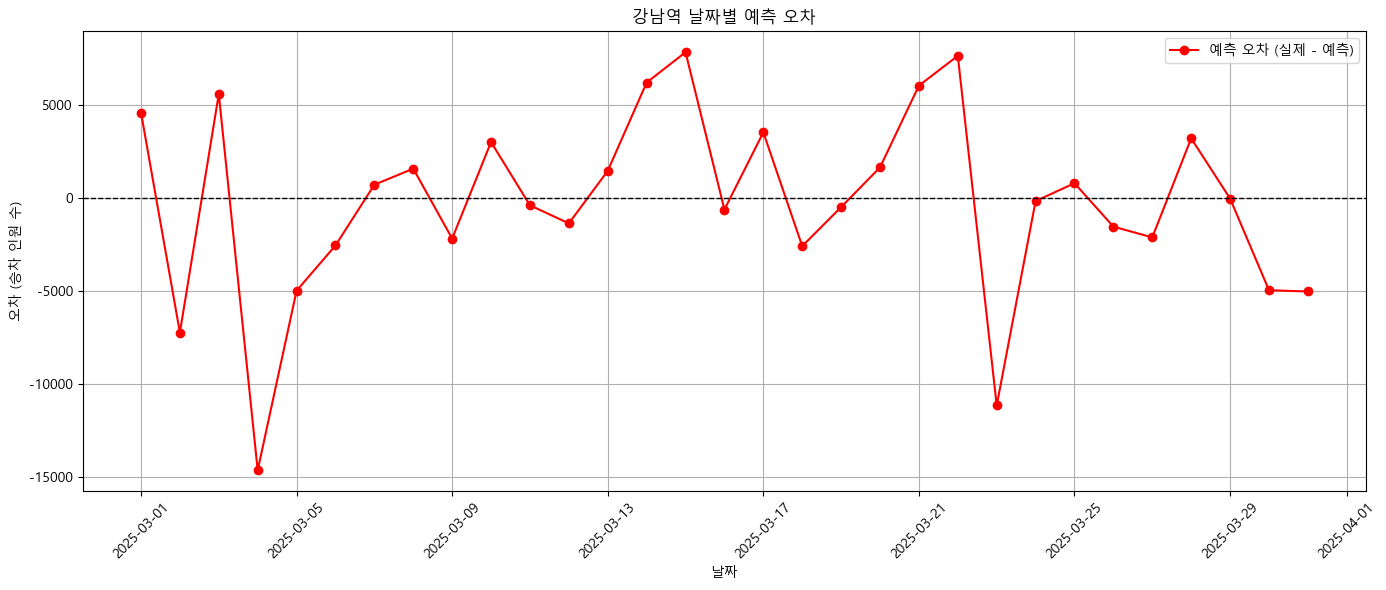

In [54]:
plot_forecast_error_over_time(merged, station_name='강남')

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_forecast_correlation(merged, station_name):
    try:
        corr = np.corrcoef(merged['actual'], merged['yhat'])[0, 1]

        plt.figure(figsize=(8, 6))
        sns.regplot(x='actual', y='yhat', data=merged, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
        plt.title(f"{station_name}역 예측값 vs 실제값 상관관계\n(Pearson r = {corr:.4f})")
        plt.xlabel("실제값 (승차 인원 수)")
        plt.ylabel("예측값 (yhat)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"상관관계 시각화 오류: {e}")


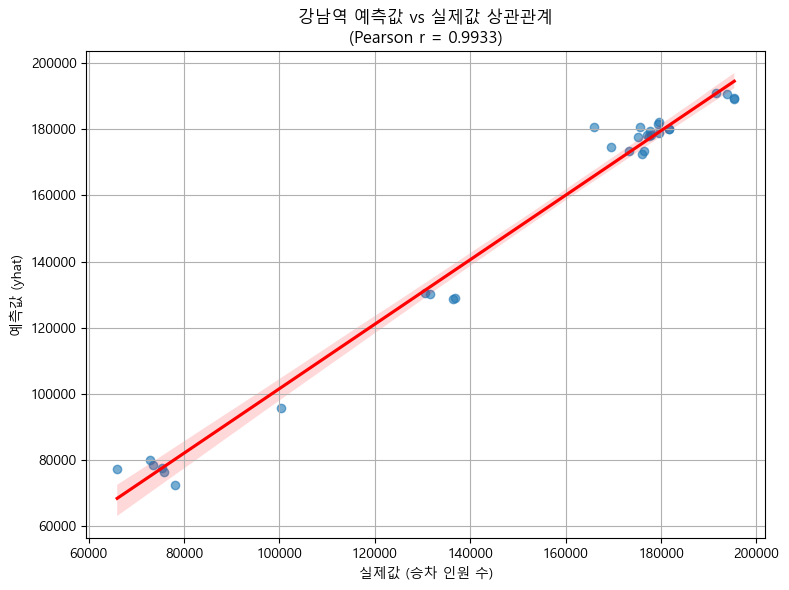

In [56]:
plot_forecast_correlation(merged, station_name='강남')